In [11]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from helper_functions import set_seeds


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [13]:
# Define the class names
class_names = ['glioma','meningioma', 'notumor', 'pituitary']

# Function to setup the model
def setup_model(weights, device, class_names):
    # Setup a ViT model instance with pretrained weights
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    # Freeze the base parameters
    freeze_parameters(model)

    # Change the classifier head
    change_classifier_head(model, class_names, device)

    return model

# Function to freeze parameters
def freeze_parameters(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

# Function to change the classifier head
def change_classifier_head(model, class_names, device):
    model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Function to set seeds
def set_seeds():
    # Add your seed setting code here
    pass

# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup the model
set_seeds()
pretrained_vit = setup_model(pretrained_vit_weights, device, class_names)

In [14]:
from torchinfo import summary

# Function to print model summary
def print_model_summary(model, input_size, col_names, col_width, row_settings):
    summary(model=model,
            input_size=input_size,
            col_names=col_names,
            col_width=col_width,
            row_settings=row_settings)

# Define the parameters for the summary
input_size = (32, 3, 224, 224) # (batch_size, color_channels, height, width)
col_names = ["input_size", "output_size", "num_params", "trainable"]
col_width = 20
row_settings = ["var_names"]

# Print the summary
print_model_summary(pretrained_vit, input_size, col_names, col_width, row_settings)

In [15]:
# Setup directory paths to train and test images
train_dir = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Training"
test_dir = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Testing"

In [16]:
# Function to get and print transforms from pretrained weights
def get_and_print_transforms(weights):
    transforms = weights.transforms()
    print(transforms)
    return transforms

# Get and print the transforms
pretrained_vit_transforms = get_and_print_transforms(pretrained_vit_weights)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [17]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Function to create a data loader
def create_dataloader(data, batch_size, shuffle, num_workers):
    return DataLoader(
        data,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
    )

# Function to create a dataset
def create_dataset(dir, transform):
    return datasets.ImageFolder(dir, transform=transform)

# Function to create data loaders
def create_data_loaders(train_dir, test_dir, transform, batch_size):
    num_workers = os.cpu_count()

    # Create datasets
    train_data = create_dataset(train_dir, transform)
    test_data = create_dataset(test_dir, transform)

    # Get class names
    class_names = train_data.classes

    # Create data loaders
    train_dataloader = create_dataloader(train_data, batch_size, True, num_workers)
    test_dataloader = create_dataloader(test_data, batch_size, False, num_workers)

    return train_dataloader, test_dataloader, class_names

In [18]:
# Function to setup data loaders
def setup_data_loaders(train_dir, test_dir, transform, batch_size):
    return create_data_loaders(train_dir, test_dir, transform, batch_size)

# Define the parameters for the data loaders
train_dir = train_dir
test_dir = test_dir
transform = pretrained_vit_transforms
batch_size = 32

# Setup the data loaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = setup_data_loaders(train_dir, test_dir, transform, batch_size)

In [ ]:
import engine
import torch.optim as optim
import torch.nn as nn

# Function to create optimizer
def create_optimizer(model, lr):
    return optim.Adam(params=model.parameters(), lr=lr)

# Function to create loss function
def create_loss_fn():
    return nn.CrossEntropyLoss()

# Function to train model
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    set_seeds()
    return engine.train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs,
                        device=device)

# Create optimizer and loss function
optimizer = create_optimizer(pretrained_vit, 1e-3)
loss_fn = create_loss_fn()

# Train the model
pretrained_vit_results = train_model(pretrained_vit, train_dataloader_pretrained, test_dataloader_pretrained, optimizer, loss_fn, 50, device)

In [21]:
import pickle

# Load the model from a file
with open('modelb16.pkl', 'rb') as f:
    pretrained_vit = pickle.load(f)
    
with open('modelb16_test.pkl', 'rb') as f:
    test_dataloader_pretrained = pickle.load(f)

with open('modelb16_results.pkl', 'rb') as f:
    pretrained_vit_results = pickle.load(f)

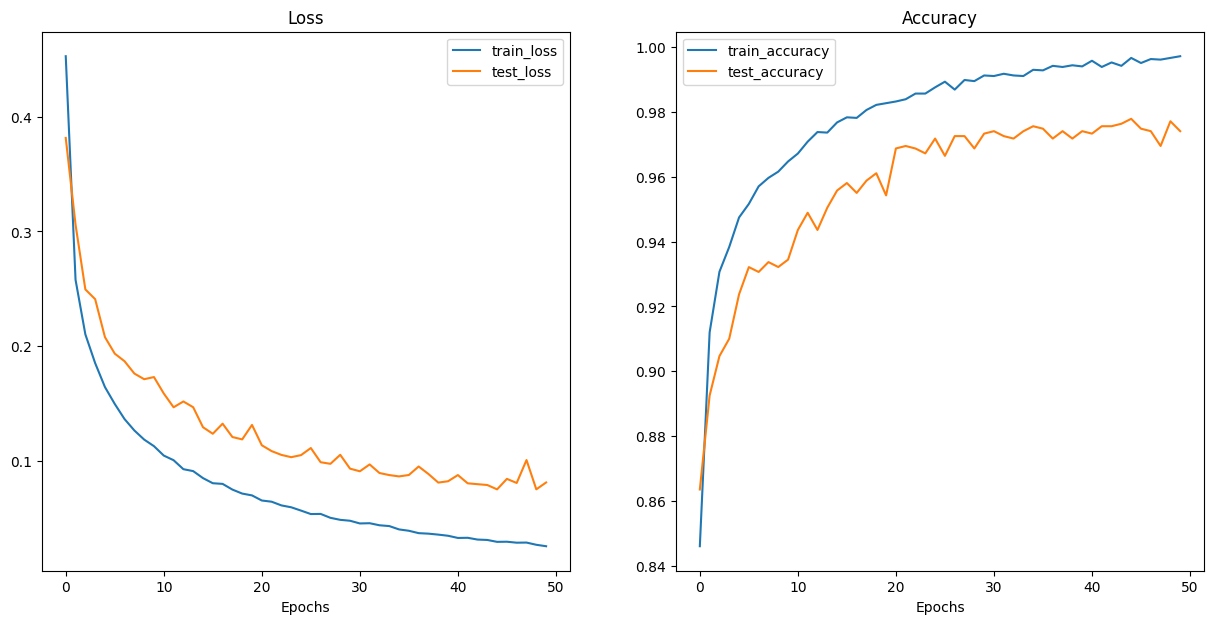

In [22]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)


In [23]:
import numpy
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the class names
class_names = ['glioma','meningioma', 'notumor', 'pituitary']

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.sigmoid(target_image_pred)
    target_image_pred_probs_soft = torch.softmax(target_image_pred, dim = 1)
    # print(target_image_pred_probs[0][0])
    target_image_pred_probs = target_image_pred_probs.cpu().numpy()
    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs_soft, dim=1)
    class_names = ['glioma','meningioma', 'notumor', 'pituitary']
    # Plot image with predicted label and probability
    for i in range (0,4):
      print(f" {class_names[i]} -> {target_image_pred_probs[0][i]}")
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)



 glioma -> 0.007167330477386713
 meningioma -> 0.4657747447490692
 notumor -> 0.05924113839864731
 pituitary -> 0.9741685390472412


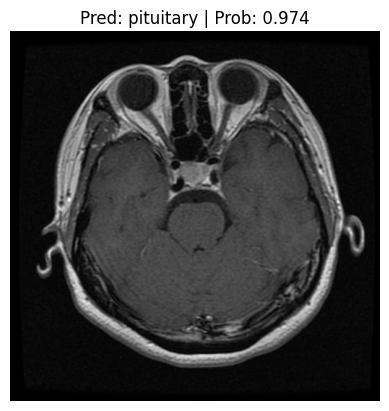

In [24]:
# Setup custom image path
custom_image_path = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Testing/pituitary/Te-pi_0011.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

              precision    recall  f1-score   support

      glioma       0.99      0.92      0.95       300
  meningioma       0.92      0.98      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.98      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.97      0.97      1311



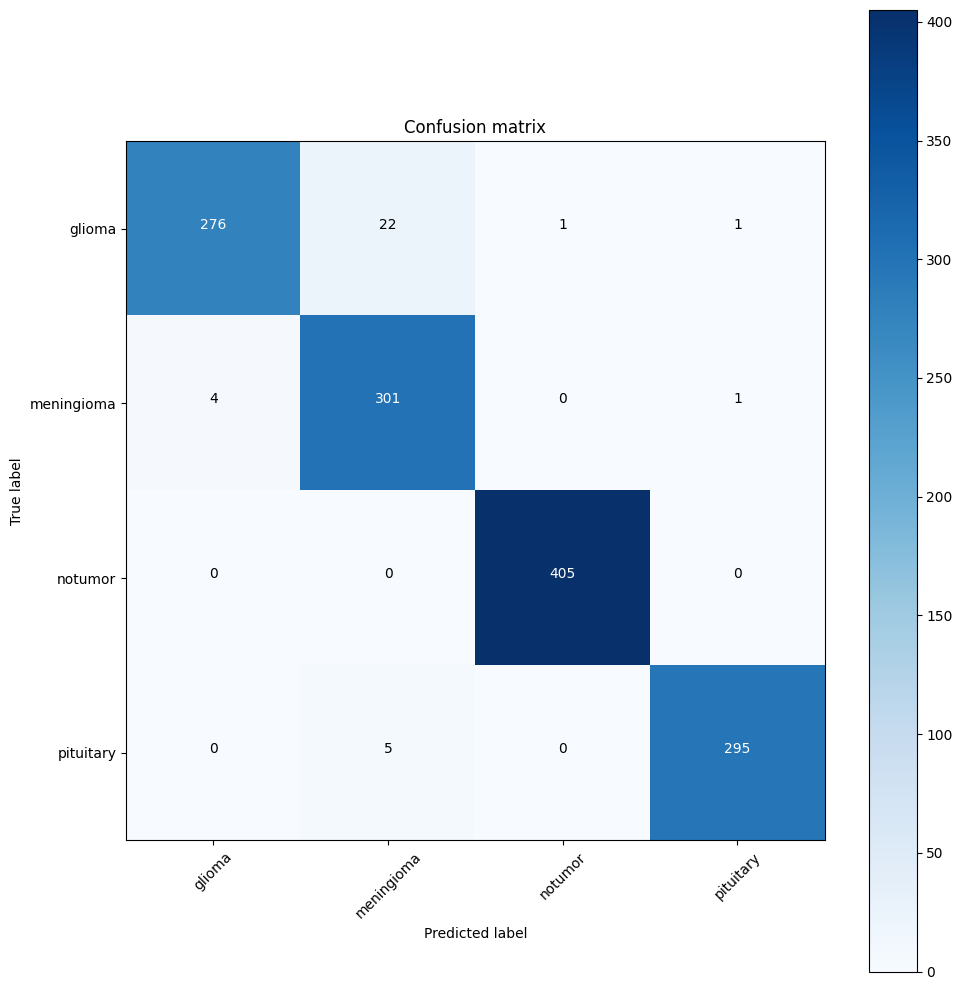

In [25]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

test_dir = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Testing"


def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    return true_labels, pred_labels

# Get true and predicted labels
true_labels, pred_labels = evaluate_model(pretrained_vit, test_dataloader_pretrained, device)

# Print classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix as a color grid
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add numbers to the grid
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()